# SET UP

### YOLO MODEL EVALUATION

In [15]:
from ultralytics import YOLO
import os
import json
import shutil
import time
import random
import csv
import matplotlib.pyplot as plt
import torch 
import gc
import numpy as np

In [7]:
import os
import json
import glob
from tqdm import tqdm
from PIL import Image

def yolo_segment_to_coco_json(images_dir, labels_dir, class_names, output_json):
    image_id = 0
    ann_id = 0

    coco = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    for i, name in enumerate(class_names):
        coco["categories"].append({
            "id": i,
            "name": name,
            "supercategory": "none"
        })

    label_files = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

    for label_file in tqdm(label_files, desc="Converting"):
        base_filename = os.path.splitext(os.path.basename(label_file))[0]

        # Check for common image extensions
        image_path = None
        for ext in [".jpg", ".jpeg", ".png"]:
            temp_path = os.path.join(images_dir, base_filename + ext)
            if os.path.exists(temp_path):
                image_path = temp_path
                break

        if image_path is None:
            continue

        image = Image.open(image_path)
        width, height = image.size

        coco["images"].append({
            "file_name": os.path.basename(image_path),
            "height": height,
            "width": width,
            "id": image_id
        })

        with open(label_file, 'r') as f:
            for line in f.readlines():
                parts = list(map(float, line.strip().split()))
                cls_id = int(parts[0])
                polygon_norm = parts[1:]

                # Convert normalized coordinates to pixel
                polygon = []
                for i in range(0, len(polygon_norm), 2):
                    x = polygon_norm[i] * width
                    y = polygon_norm[i+1] * height
                    polygon.append(x)
                    polygon.append(y)

                # Skip invalid polygons
                # if len(polygon) < 6:
                #     continue

                x_coords = polygon[0::2]
                y_coords = polygon[1::2]
                x_min = min(x_coords)
                y_min = min(y_coords)
                box_width = max(x_coords) - x_min
                box_height = max(y_coords) - y_min
                area = box_width * box_height

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": cls_id,
                    "segmentation": [polygon],
                    "area": area,
                    "bbox": [x_min, y_min, box_width, box_height],
                    "iscrowd": 0
                })
                ann_id += 1

        image_id += 1

    with open(output_json, "w") as f:
        json.dump(coco, f, indent=4)

    print(f"✅ Saved COCO-format JSON to: {output_json}")
    
class_names = [
    "unbet",
    "betrivers",
    "fanduel",
    "betway",
    "caesars",
    "bally",
    "draftkings",
    "pointsbet",
    "bet365",
    "fanatics",
    "betparx",
    "betmgm",
    "gilariver",
    "casino"
]

yolo_segment_to_coco_json(
    images_dir="DATASET/images/val",
    labels_dir="DATASET/labels/val",
    class_names=class_names,
    output_json="val_segment_coco.json"
)

Converting:   0%|          | 0/411 [00:00<?, ?it/s]

Converting: 100%|██████████| 411/411 [00:11<00:00, 34.83it/s]


✅ Saved COCO-format JSON to: val_segment_coco.json


In [3]:
def YoloEvaluate(yolo_list, YOLO_RUN, INPUT_DATA, INPUT_SEGMENT_GROUND_TRUTH_COCO, CLEAR_SOURCE=False):
    """
    Evaluates a list of YOLO models on a given dataset and generates fixed COCO-style predictions.

    Parameters:
        yolo_list (list of dict): List of YOLO models, each with keys:
            - "model_name": name of the model (str)
            - "size": size description (e.g., 's', 'm') (str)
            - "weight_path": path to the trained YOLO model weights (str)
        YOLO_RUN (str): Path to the directory where evaluation results will be saved.
        INPUT_DATA (str): Path to the YAML file containing dataset info for validation.
        INPUT_SEGMENT_GROUND_TRUTH_COCO (str): Path to the ground truth COCO-format annotation JSON file.
        CLEAR_SOURCE (bool): If True, clears the YOLO_RUN directory before running evaluations.

    This function performs:
        - Optional clearing of the YOLO_RUN directory.
        - For each YOLO model in the list:
            - Runs validation using the Ultralytics YOLO `val()` method.
            - Loads the original COCO ground truth JSON to map filenames to image IDs.
            - Fixes the YOLO output `predictions.json` to correct image IDs and class IDs.
            - Saves the corrected predictions to `predictions_fixed.json`.
    
    Notes:
        - The YOLO output `category_id` is adjusted by subtracting 1 (assumes original classes start at 1).
        - Requires that YOLO predictions contain `image_id` as the filename without extension.

    Outputs:
        - COCO-format prediction file `predictions_fixed.json` for each evaluated model.

    Example model config:
        yolo_list = [
            {
                "model_name": "yolov8-seg",
                "size": "n",
                "weight_path": "weights/yolov8n-seg.pt"
            },
            ...
        ]
    """
    
    for model in yolo_list:
        if not os.path.exists(model["weight_path"]):
            print("[MISSING]", model["weight_path"])
            
    print("----------")
    
    # Optionally delete the existing evaluation output directory
    if CLEAR_SOURCE:
        if os.path.exists(YOLO_RUN):
            shutil.rmtree(YOLO_RUN)

    # Create the output directory if it doesn't exist
    if not os.path.exists(YOLO_RUN):
        os.makedirs(YOLO_RUN)

    # Loop through each model in the list
    for yolo_item in yolo_list:
        model_name = yolo_item["model_name"]
        model_size = yolo_item["size"]
        out_name = model_name + "_" + model_size

        save_dir = os.path.join(YOLO_RUN, out_name)

        # Load the YOLO model using the provided weight path
        model = YOLO(yolo_item["weight_path"])

        # Run validation and save results to the specified directory
        model.val(
            data=INPUT_DATA,
            save_json=True,
            save=True,
            project=save_dir,
            name=model_name
        )

        # Load the ground truth COCO annotations
        with open(INPUT_SEGMENT_GROUND_TRUTH_COCO) as f:
            coco_gt = json.load(f)

        # Map image filenames (without extension) to their COCO image IDs
        file_to_id = {}
        for img in coco_gt["images"]:
            filename = img["file_name"].rsplit(".", 1)[0]
            file_to_id[filename] = img["id"]

        # Load the predictions generated by YOLO
        predictions_file = os.path.join(save_dir, model_name, "predictions.json")
        with open(predictions_file) as f:
            preds = json.load(f)

        # Fix image_id and category_id in each prediction
        for pred in preds:
            filename = pred["image_id"]
            if filename in file_to_id:
                pred["image_id"] = file_to_id[filename]
                pred["category_id"] = pred["category_id"] - 1  # Adjust class index
            else:
                print(f"[WARN] Cannot find image ID for: {filename}")

        # Save the corrected predictions to a new file
        predictions_fixed_file = os.path.join(save_dir, model_name, "predictions_fixed.json")
        with open(predictions_fixed_file, "w") as f:
            json.dump(preds, f)

        print()
        print("Created predictions_fixed.json")
        print()
        print(f"{model_name} is evaluated.")
        
                # === Giải phóng bộ nhớ sau mỗi mô hình ===
        del model
        torch.cuda.empty_cache()
        gc.collect()


In [4]:
yolo_list = [
    {
        "model_name": "yolov8_seg",
        "size": "s",
        "weight_path": "WEIGHTS/yolov8_seg/yolov8_seg_best_s.pt",
    },
    
    {
        "model_name": "yolov8_seg",
        "size": "m",
        "weight_path": "WEIGHTS/yolov8_seg/yolov8_seg_best_m.pt",
    },
    
    {
        "model_name": "yolov8_seg",
        "size": "l",
        "weight_path": "WEIGHTS/yolov8_seg/yolov8_seg_best_l.pt",
    },
    
    {
        "model_name": "yolo11_seg",
        "size": "s",
        "weight_path": "WEIGHTS\yolo11_seg\yolo11_seg_best_s.pt",
    },
    
    {
        "model_name": "yolo11_seg",
        "size": "m",
        "weight_path": "WEIGHTS/yolo11_seg/yolo11_seg_best_m.pt",
    },
    
    {
        "model_name": "yolo11_seg",
        "size": "l",
        "weight_path": "WEIGHTS/yolo11_seg/yolo11_seg_best_l.pt",
    },
    ########### augmentation
    {
        "model_name": "yolov8_seg",
        "size": "s",
        "weight_path": "WEIGHTS/aug/yolov8_seg/yolov8_seg_aug_best_s.pt",
    },
    
    {
        "model_name": "yolov8_seg",
        "size": "m",
        "weight_path": "WEIGHTS/aug/yolov8_seg/yolov8_seg_aug_best_m.pt",
    },
    
    {
        "model_name": "yolov8_seg",
        "size": "l",
        "weight_path": "WEIGHTS/aug/yolov8_seg/yolov8_seg_aug_best_l.pt",
    },
    
    {
        "model_name": "yolo11_seg",
        "size": "s",
        "weight_path": "WEIGHTS/aug/yolo11_seg/yolo11_seg_aug_best_s.pt",
    },
    
    {
        "model_name": "yolo11_seg",
        "size": "m",
        "weight_path": "WEIGHTS/aug/yolo11_seg/yolo11_seg_aug_best_m.pt",
    },
    
    {
        "model_name": "yolo11_seg",
        "size": "l",
        "weight_path": "WEIGHTS/aug/yolo11_seg/yolo11_seg_aug_best_l.pt",
    }
]

YOLO_RUN = "YOLO_RUN"
INPUT_DATA = "DATASET/data.yaml"
INPUT_SEGMENT_GROUND_TRUTH_COCO = "val_segment_coco.json"

In [5]:
YoloEvaluate(
    yolo_list, 
    YOLO_RUN, 
    INPUT_DATA,
    INPUT_SEGMENT_GROUND_TRUTH_COCO,
    CLEAR_SOURCE = True
    )

----------
Ultralytics 8.3.146  Python-3.9.18 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,785,018 parameters, 0 gradients, 42.5 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 271.9103.2 MB/s, size: 192.7 KB)


val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:09<03:47,  9.10s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:20<04:06, 10.26s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [03:45<00:00,  8.67s/it]


                   all        411       3957      0.879      0.778      0.842      0.702      0.879      0.777      0.844      0.513
                 unbet        388       3340      0.921      0.814      0.909      0.697      0.915      0.808      0.893      0.479
             betrivers         13         17      0.969      0.765      0.879      0.713      0.969      0.765      0.879      0.453
               fanduel        161        277      0.953       0.87      0.951      0.785      0.949      0.866      0.955      0.511
                betway         60         91      0.929      0.858      0.915      0.774      0.929      0.858      0.918      0.548
               caesars          4         10      0.847      0.557       0.66       0.56      0.846      0.552       0.66      0.368
                 bally         52         56      0.932      0.893      0.952      0.725      0.932      0.893      0.952      0.424
            draftkings         49         59      0.962      0.864   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:09<03:56,  9.47s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:18<03:41,  9.24s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [03:22<00:00,  7.77s/it]


                   all        411       3957      0.889      0.766      0.831      0.694      0.889      0.766      0.831      0.515
                 unbet        388       3340      0.937      0.796       0.91      0.715      0.933      0.792      0.901      0.492
             betrivers         13         17      0.871      0.765      0.853      0.732      0.871      0.765      0.853      0.421
               fanduel        161        277      0.986      0.874      0.959      0.795      0.978      0.866      0.957      0.523
                betway         60         91      0.957      0.846      0.903      0.763      0.963      0.851      0.906      0.553
               caesars          4         10      0.816        0.3      0.468      0.394      0.816        0.3      0.468       0.25
                 bally         52         56      0.944      0.911      0.924      0.689      0.944      0.911      0.924      0.428
            draftkings         49         59      0.968      0.831   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:13<05:37, 13.50s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:28<05:41, 14.22s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [05:16<00:00, 12.17s/it]


                   all        411       3957       0.83      0.755      0.777       0.65      0.826      0.752      0.773      0.458
                 unbet        388       3340      0.822      0.882      0.905      0.693      0.811      0.869      0.891      0.475
             betrivers         13         17      0.689      0.882      0.886      0.681      0.689      0.882      0.886      0.379
               fanduel        161        277      0.938      0.903      0.943      0.771      0.938      0.903      0.944      0.497
                betway         60         91       0.91      0.886      0.913      0.774      0.898      0.875      0.905      0.549
               caesars          4         10          1      0.408      0.591      0.466          1      0.408      0.591      0.339
                 bally         52         56        0.9      0.911      0.916      0.704        0.9      0.911      0.916      0.389
            draftkings         49         59      0.944      0.847   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:14<05:54, 14.18s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:27<05:22, 13.45s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [05:11<00:00, 11.99s/it]


                   all        411       3957      0.776      0.698      0.749      0.593      0.778      0.699      0.753      0.434
                 unbet        388       3340       0.82      0.827      0.857      0.638      0.815      0.822      0.851      0.449
             betrivers         13         17      0.715      0.647      0.645      0.458      0.716      0.647      0.645      0.272
               fanduel        161        277      0.863      0.866      0.905      0.722      0.866       0.87      0.908       0.48
                betway         60         91      0.899       0.78      0.868      0.737        0.9       0.78      0.872      0.523
               caesars          4         10      0.642      0.363      0.491      0.296      0.641      0.362      0.491      0.225
                 bally         52         56      0.878      0.899      0.921      0.683      0.878      0.899      0.921      0.409
            draftkings         49         59      0.839      0.847   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:10<04:26, 10.65s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:20<03:59,  9.97s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [03:55<00:00,  9.06s/it]


                   all        411       3957      0.818      0.752      0.789      0.664      0.819      0.753      0.792      0.479
                 unbet        388       3340      0.822      0.855      0.887      0.684      0.813      0.846      0.878      0.469
             betrivers         13         17      0.875      0.824      0.797      0.676      0.875      0.824      0.797        0.4
               fanduel        161        277      0.874      0.899      0.934      0.763       0.87      0.896      0.929      0.504
                betway         60         91       0.93      0.857        0.9      0.764       0.93      0.857        0.9      0.533
               caesars          4         10      0.738        0.4      0.591       0.47      0.738        0.4      0.591      0.352
                 bally         52         56      0.926      0.897      0.902      0.702      0.926      0.897      0.902      0.438
            draftkings         49         59      0.867      0.881   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:11<04:43, 11.33s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:24<04:50, 12.12s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [04:29<00:00, 10.37s/it]


                   all        411       3957      0.809      0.719      0.791      0.625      0.812      0.721      0.793      0.467
                 unbet        388       3340      0.825       0.85      0.878       0.67      0.817      0.841      0.872      0.462
             betrivers         13         17      0.758      0.554      0.747      0.647      0.758      0.553      0.747      0.319
               fanduel        161        277      0.743      0.888      0.916      0.741      0.743      0.888      0.913      0.474
                betway         60         91      0.906      0.847        0.9      0.733      0.894      0.836      0.887      0.521
               caesars          4         10      0.972        0.4      0.504      0.262      0.973        0.4        0.5      0.218
                 bally         52         56      0.801      0.861      0.919      0.679      0.801       0.86      0.919      0.412
            draftkings         49         59      0.962      0.854   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:13<05:35, 13.41s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:28<05:49, 14.55s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [06:03<00:00, 13.97s/it]


                   all        411       3957      0.868      0.758      0.789      0.648      0.866      0.757      0.785      0.456
                 unbet        388       3340        0.9      0.863      0.925      0.709       0.89      0.853      0.915      0.499
             betrivers         13         17      0.776      0.882      0.923      0.755      0.774      0.882      0.923      0.407
               fanduel        161        277      0.905       0.91      0.964       0.78      0.894      0.899      0.953      0.516
                betway         60         91      0.917       0.89      0.952      0.816      0.916       0.89      0.948      0.575
               caesars          4         10      0.692        0.5      0.473      0.343      0.691        0.5      0.457      0.266
                 bally         52         56      0.931      0.893      0.979      0.772      0.931      0.893      0.979      0.502
            draftkings         49         59      0.982      0.914   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:12<05:07, 12.28s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:26<05:22, 13.44s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [04:40<00:00, 10.78s/it]


                   all        411       3957       0.72       0.87      0.825      0.684      0.719      0.869      0.824      0.497
                 unbet        388       3340      0.802      0.925      0.934      0.738      0.789       0.91      0.921      0.511
             betrivers         13         17      0.645      0.882      0.894      0.704      0.645      0.882      0.894      0.441
               fanduel        161        277      0.873      0.957      0.975      0.802      0.873      0.957      0.969      0.534
                betway         60         91      0.886      0.945      0.954      0.839      0.886      0.945      0.959      0.595
               caesars          4         10      0.712      0.746      0.769      0.514      0.712      0.746      0.769      0.414
                 bally         52         56      0.912      0.926      0.968       0.78      0.912      0.926      0.968      0.463
            draftkings         49         59      0.935      0.966   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:10<04:10, 10.02s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:22<04:41, 11.72s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [04:18<00:00,  9.95s/it]


                   all        411       3957       0.88      0.832      0.901      0.761       0.88      0.832        0.9      0.546
                 unbet        388       3340      0.954       0.83      0.943      0.753      0.947      0.824      0.925      0.513
             betrivers         13         17      0.932      0.811      0.919      0.756      0.932      0.811      0.942      0.484
               fanduel        161        277      0.969      0.904      0.981      0.827      0.973      0.908      0.982      0.542
                betway         60         91      0.988      0.904      0.966      0.845      0.988      0.904      0.963      0.609
               caesars          4         10      0.825        0.7      0.843      0.705      0.825        0.7      0.832      0.447
                 bally         52         56      0.923      0.946      0.977      0.769      0.923      0.946      0.977       0.44
            draftkings         49         59      0.978      0.932   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:12<05:19, 12.79s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:26<05:18, 13.29s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [04:28<00:00, 10.32s/it]


                   all        411       3957      0.896      0.693      0.811      0.657      0.896      0.693      0.809      0.472
                 unbet        388       3340      0.947       0.76       0.91      0.694      0.942      0.756        0.9      0.487
             betrivers         13         17          1      0.425      0.837       0.66          1      0.425      0.837      0.388
               fanduel        161        277      0.956      0.852      0.964      0.768      0.952      0.848      0.958      0.502
                betway         60         91      0.951       0.86      0.961      0.816      0.951       0.86      0.961      0.561
               caesars          4         10      0.883        0.5      0.691      0.492      0.883        0.5      0.687      0.339
                 bally         52         56      0.905      0.875      0.959      0.754      0.905      0.875      0.959      0.494
            draftkings         49         59      0.981      0.862   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:08<03:41,  8.88s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:17<03:33,  8.88s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [03:34<00:00,  8.27s/it]


                   all        411       3957      0.854      0.795      0.887      0.724      0.853      0.794      0.884      0.507
                 unbet        388       3340      0.946      0.777       0.92      0.692      0.942      0.774       0.91      0.485
             betrivers         13         17      0.969      0.765      0.898      0.766      0.969      0.765      0.903      0.426
               fanduel        161        277      0.948      0.859      0.969      0.778      0.944      0.855      0.968      0.517
                betway         60         91          1      0.816      0.958      0.798      0.987      0.805       0.94      0.536
               caesars          4         10      0.787        0.5       0.69      0.561      0.787        0.5       0.69      0.378
                 bally         52         56      0.932      0.739      0.957      0.738      0.932      0.739      0.957       0.44
            draftkings         49         59      0.982      0.916   

val: Scanning D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\labels\val.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]

val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\Cavaliers_vs_Nets_1305_Thunv10_000055.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001800.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001819.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001936.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\epicducks_posters_1205_NghiaNT20_001946.jpg: 1 duplicate labels removed
val: D:\semester_9_AI_Final_doc\VAL_SEG_MODEL\DATASET\images\val\patrick_tenacious_1105_khaihoan2003_000239.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:11<04:51, 11.65s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:23<04:48, 12.03s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [04:14<00:00,  9.78s/it]


                   all        411       3957      0.903      0.791      0.889      0.736      0.905      0.792      0.889      0.525
                 unbet        388       3340      0.948      0.818      0.932      0.725      0.942      0.812      0.917      0.501
             betrivers         13         17       0.99      0.706      0.915       0.79      0.991      0.706      0.915      0.457
               fanduel        161        277      0.983      0.825      0.973      0.795      0.983      0.824       0.97      0.519
                betway         60         91      0.997      0.901      0.983      0.856      0.997      0.901      0.978      0.581
               caesars          4         10          1      0.632      0.912      0.713          1      0.632      0.912      0.504
                 bally         52         56      0.926        0.9      0.956       0.72      0.926        0.9      0.956      0.412
            draftkings         49         59          1      0.925   

# Fix prediction.json - yolo - AUG

In [6]:

Json_prediction_yolo_aug = [
    "YOLO_RUN/yolo11_seg_l/yolo11_seg2/predictions.json",
    "YOLO_RUN/yolo11_seg_m/yolo11_seg2/predictions.json",
    "YOLO_RUN/yolo11_seg_s/yolo11_seg2/predictions.json",
    "YOLO_RUN/yolov8_seg_l/yolov8_seg2/predictions.json",
    "YOLO_RUN/yolov8_seg_m/yolov8_seg2/predictions.json",
    "YOLO_RUN/yolov8_seg_s/yolov8_seg2/predictions.json"
]

INPUT_SEGMENT_GROUND_TRUTH_COCO = "val_segment_coco.json"

# Load the ground truth COCO annotations
with open(INPUT_SEGMENT_GROUND_TRUTH_COCO) as f:
    coco_gt = json.load(f)

# Map image filenames (without extension) to their COCO image IDs
file_to_id = {}
for img in coco_gt["images"]:
    filename = img["file_name"].rsplit(".", 1)[0]
    file_to_id[filename] = img["id"]

for json_need in Json_prediction_yolo_aug:
    predictions_file = json_need

    with open(predictions_file) as f:
        preds = json.load(f)

    # Fix image_id and category_id
    for pred in preds:
        filename = pred["image_id"]
        if filename in file_to_id:
            pred["image_id"] = file_to_id[filename]
            pred["category_id"] = pred["category_id"] - 1
        else:
            print(f"[WARN] Cannot find image ID for: {filename}")

    # Save in the same directory as predictions.json
    prediction_dir = os.path.dirname(predictions_file)
    predictions_fixed_file = os.path.join(prediction_dir, "predictions_fixed.json")

    with open(predictions_fixed_file, "w") as f:
        json.dump(preds, f)

    print(f"Created: {predictions_fixed_file}")


Created: YOLO_RUN/yolo11_seg_l/yolo11_seg2\predictions_fixed.json
Created: YOLO_RUN/yolo11_seg_m/yolo11_seg2\predictions_fixed.json
Created: YOLO_RUN/yolo11_seg_s/yolo11_seg2\predictions_fixed.json
Created: YOLO_RUN/yolov8_seg_l/yolov8_seg2\predictions_fixed.json
Created: YOLO_RUN/yolov8_seg_m/yolov8_seg2\predictions_fixed.json
Created: YOLO_RUN/yolov8_seg_s/yolov8_seg2\predictions_fixed.json


### Mask RCNN MODEL EVALUATION

In [20]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [8]:
def MaskRCNNEvaluate(MASK_RCNN_LIST, MASK_RCNN_RUN, class_names, CLEAR_SOURCE=False, IOU_THRES=0.7, DEVICE="cuda"):
    """
    Evaluates a list of Mask R-CNN models on a validation dataset using Detectron2 framework.

    Parameters:
        MASK_RCNN_LIST (list of dict): List of Mask R-CNN model configurations, each dict contains:
            - "model_name": descriptive model name (str)
            - "model_zoo": model zoo config yaml path (str)
            - "weight_path": path to trained model weights (str)
        MASK_RCNN_RUN (str): Directory path where evaluation outputs (e.g., logs, results) will be saved.
        class_names (list of str): List of class names for the dataset.
        CLEAR_SOURCE (bool): If True, deletes the contents of MASK_RCNN_RUN directory before evaluation.
        IOU_THRES (float): Intersection-over-Union threshold to filter predictions during inference.
        DEVICE (str): Device to run model on, e.g., "cuda" or "cpu".

    This function:
        - Optionally clears the output directory.
        - For each model in the list:
            - Sets up Detectron2 config with the specified model zoo config and weights.
            - Adjusts number of classes and score threshold for inference.
            - Creates a DefaultPredictor for inference.
            - Prepares COCOEvaluator and validation data loader.
            - Runs evaluation and prints summary.

    Note:
        - Assumes the validation dataset "bet_val" is already registered in Detectron2 DatasetCatalog.
        - Uses COCO format annotations for evaluation.
    """

    # Clear the output directory if requested
    if CLEAR_SOURCE:
        if os.path.exists(MASK_RCNN_RUN):
            shutil.rmtree(MASK_RCNN_RUN)

    # Create the output directory if it does not exist
    if not os.path.exists(MASK_RCNN_RUN):
        os.makedirs(MASK_RCNN_RUN)

    # Loop through each Mask R-CNN model config for evaluation
    for mrcnn_item in MASK_RCNN_LIST:
        model_name = mrcnn_item["model_name"]
        var_model_zoo = mrcnn_item["model_zoo"]
        weight_path = mrcnn_item["weight_path"]

        # Create Detectron2 configuration and merge with the model zoo config file
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file(var_model_zoo))

        # Set the model weights from the zoo checkpoint URL initially
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(var_model_zoo)

        # Override with the custom trained weights path
        cfg.MODEL.WEIGHTS = weight_path

        # Set the number of classes in ROI heads to match dataset classes
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names)

        # Set the inference score threshold (confidence threshold)
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = IOU_THRES

        # Set the device to run inference on (CPU or GPU)
        cfg.MODEL.DEVICE = DEVICE

        # Create the predictor object that wraps the model and config for inference
        predictor = DefaultPredictor(cfg)

        # Prepare output directory for this model's evaluation results
        output_dir = os.path.join(MASK_RCNN_RUN, model_name)

        # Create COCOEvaluator for dataset "bet_val"
        # This evaluator computes standard COCO metrics for detection/segmentation
        evaluator = COCOEvaluator("bet_val", output_dir=output_dir)

        # Build the data loader for the validation dataset
        val_loader = build_detection_test_loader(cfg, "bet_val")

        # Run inference and evaluation, print results to console
        inference_on_dataset(predictor.model, val_loader, evaluator)

        print()
        print(f"{model_name} evaluated")
        print()

In [9]:
if "bet_val" in DatasetCatalog.list():
    DatasetCatalog.remove("bet_val")
    MetadataCatalog.remove("bet_val")
    
register_coco_instances(
    "bet_val",
    {},
    "val_segment_coco.json",
    "DATASET/images/val"
)

print("Number of classes:", len(class_names))

Number of classes: 14


In [10]:
# Example list of Mask R-CNN model configurations to evaluate
MASK_RCNN_LIST = [
    {
        "model_name": "MRCNN_BB_RESNET50",
        "model_zoo": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
        "weight_path": "WEIGHTS/Mask_RCNN/BB_RESNET50/BB_RESNET50_model_final.pth"
    },
    {
        "model_name": "MRCNN_BB_RESNET101",
        "model_zoo": "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml",
        "weight_path": "WEIGHTS/Mask_RCNN/BB_RESNET101/BB_RESNET101_model_final.pth"
    },
    
    # ########## Augmentation
    {
        "model_name": "MRCNN_BB_RESNET50_AUG",
        "model_zoo": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
        "weight_path": "WEIGHTS/aug/Mask_RCNN/BB_RESNET50/BB_RESNET50_model_aug_final.pth"
    },
    {
        "model_name": "MRCNN_BB_RESNET101_AUG",
        "model_zoo": "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml",
        "weight_path": "WEIGHTS/aug/Mask_RCNN/BB_RESNET101/BB_RESNET101_model_aug_final.pth"
    }
]

# Directory to save evaluation outputs
MASK_RCNN_RUN = "MASK_RCNN_RUN"

In [11]:
MaskRCNNEvaluate(
    MASK_RCNN_LIST, 
    MASK_RCNN_RUN, 
    class_names,
    CLEAR_SOURCE = True
    )


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

d:\Anaconda\envs\cuda\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.40s).
Accumulating evaluation results...
DONE (t=0.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.71s).
Accumulating evaluation results...
DONE (t=0.30s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.53s).
Accumulating evaluation results...
DONE (t=0.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.49s).
Accumulating evaluation results...
DONE (t=0.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.685
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

# Implementation

### AP50, AP75, mAP

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import seaborn as sns
import pandas as pd
from math import pi
import os
import math

In [ ]:
def get_ap_per_class(coco_eval, coco_gt):
    precision = coco_eval.eval['precision']  # [TxRxKxAxM]
    cat_ids = coco_gt.getCatIds()
    cat_names = [c['name'] for c in coco_gt.loadCats(cat_ids)]
    
    ap_50 = []
    ap_75 = []
    
    for idx, cat_id in enumerate(cat_ids):
        p_50 = precision[0, :, idx, 0, 2]
        p_75 = precision[5, :, idx, 0, 2]
        ap_50.append(np.mean(p_50[p_50 > -1]) if np.any(p_50 > -1) else 0)
        ap_75.append(np.mean(p_75[p_75 > -1]) if np.any(p_75 > -1) else 0)

    return cat_names, ap_50, ap_75

def evaluate_model(gt_json, dt_json, model_name):
    coco_gt = COCO(gt_json)
    coco_dt = coco_gt.loadRes(dt_json)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='segm')
    coco_eval.evaluate()
    coco_eval.accumulate()
    print(f"\n=== {model_name} Evaluation ===")
    # coco_eval.summarize()
    return get_ap_per_class(coco_eval, coco_gt)

    
def plot_ap_per_class(cat_names, ap_50, ap_75, model_name, save_path):
    x = np.arange(len(cat_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(16, 6))

    ax.bar(x - width/2, ap_50, width=width, label='IoU=0.50')
    ax.bar(x + width/2, ap_75, width=width, label='IoU=0.75')

    ax.set_ylabel('Average Precision')
    ax.set_xlabel('Class')
    ax.set_title(f'AP per Class for {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(cat_names, rotation=45)
    ax.set_ylim(0, 1.0)
    ax.legend()
    ax.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    

def plot_combined_heatmap(models_data, metric='ap50', save_path='heatmap.png'):
    # metric: 'ap50' or 'ap75'
    data = []
    for cat_names, ap_50, ap_75, model_name in models_data:
        ap_values = ap_50 if metric == 'ap50' else ap_75
        for cls, ap in zip(cat_names, ap_values):
            data.append({'Model': model_name, 'Class': cls, 'AP': ap})

    df = pd.DataFrame(data)
    pivot = df.pivot(index="Model", columns="Class", values="AP")
    plt.figure(figsize=(20, len(set([x[3] for x in models_data]))))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.title(f'Heatmap of AP@{"0.50" if metric=="ap50" else "0.75"} per Class')
    plt.ylabel("Model")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    
def plot_radar_chart(models_data, metric, save_path):
    # Chọn giá trị AP theo metric
    model_names = [m[3] for m in models_data]
    class_names = models_data[0][0]
    N = len(class_names)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # hoàn thành vòng tròn

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    for cat_names, ap_50, ap_75, model_name in models_data:
        values = ap_50 if metric == 'ap50' else ap_75
        values += values[:1]  # nối lại điểm đầu
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], class_names, color='black', size=10, rotation=45)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=8)
    plt.ylim(0, 1)

    plt.title(f'Radar Chart of AP@{"0.50" if metric == "ap50" else "0.75"} per Class', size=15)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def plot_individual_radar_chart(cat_names, ap_50, ap_75, model_name, save_path_50, save_path_75):
    """
    Plot individual radar chart for a single model showing both AP50 and AP75 metrics.
    
    Parameters:
        cat_names (list): List of class names
        ap_50 (list): AP values at IoU=0.50
        ap_75 (list): AP values at IoU=0.75
        model_name (str): Name of the model
        save_path_50 (str): Path to save AP50 radar chart
        save_path_75 (str): Path to save AP75 radar chart
    """
    N = len(cat_names)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # hoàn thành vòng tròn

    # Plot AP50 radar chart
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    values_50 = ap_50 + ap_50[:1]  # nối lại điểm đầu
    ax.plot(angles, values_50, linewidth=3, linestyle='solid', label=f'{model_name} AP@0.50', color='blue')
    ax.fill(angles, values_50, alpha=0.25, color='blue')
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], cat_names, color='black', size=12)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    plt.ylim(0, 1)
    
    plt.title(f'{model_name} - AP@0.50 per Class', size=16, pad=20)
    plt.tight_layout()
    plt.savefig(save_path_50, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot AP75 radar chart
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    values_75 = ap_75 + ap_75[:1]  # nối lại điểm đầu
    ax.plot(angles, values_75, linewidth=3, linestyle='solid', label=f'{model_name} AP@0.75', color='red')
    ax.fill(angles, values_75, alpha=0.25, color='red')
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], cat_names, color='black', size=12)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    plt.ylim(0, 1)
    
    plt.title(f'{model_name} - AP@0.75 per Class', size=16, pad=20)
    plt.tight_layout()
    plt.savefig(save_path_75, dpi=300, bbox_inches='tight')
    plt.close()
    
def combine_images(image_paths, output_path, images_per_row=3):
    """Combine multiple images into a grid and save to output_path."""
    images = [Image.open(p) for p in image_paths]

    # Assume all images are the same size
    width, height = images[0].size
    n_images = len(images)
    rows = math.ceil(n_images / images_per_row)

    # Create a blank canvas
    combined_image = Image.new('RGB', (images_per_row * width, rows * height), color=(255, 255, 255))

    for idx, img in enumerate(images):
        row, col = divmod(idx, images_per_row)
        combined_image.paste(img, (col * width, row * height))

    combined_image.save(output_path)

def CombineEvaluation(COMBINE_LIST, VAL_SEGMENT_COCO, PLOT_FOLDER, CSV_FOLDER, PLOT_ALL=False, CSV_REPORT_ALL=False, PLOT_INDIVIDUAL_RADAR=True):
    """
    Evaluate multiple model predictions, generate per-class Average Precision (AP) metrics,
    and create summary plots and CSV reports.

    Parameters:
        COMBINE_LIST (list of dict): List of prediction results to evaluate. Each dict should contain:
            - "predict_result": path or data for the model's prediction results
            - "name": model name
            - "size": model size or variant (e.g., "small", "large")
        VAL_SEGMENT_COCO (str): Path to the ground truth validation dataset in COCO JSON format.
        PLOT_FOLDER (str): Directory to save the evaluation plots.
        CSV_FOLDER (str): Directory to save the detailed CSV reports.
        PLOT_ALL (bool): If True, generate and save per-class AP plots for each model.
        CSV_REPORT_ALL (bool): If True, generate and save detailed per-class AP CSV reports for each model.
        PLOT_INDIVIDUAL_RADAR (bool): If True, generate individual radar charts for each model.

    Functionality:
        - Creates directories for saving plots and CSV reports if they do not exist.
        - Iterates over each model's prediction results in COMBINE_LIST:
            + Calls 'evaluate_model' to compute AP metrics per class.
            + Stores class names and AP50/AP75 scores for later summary visualization.
            + If PLOT_ALL is True, plots per-class AP graphs for the model.
            + If CSV_REPORT_ALL is True, saves the per-class AP metrics as CSV files.
            + If PLOT_INDIVIDUAL_RADAR is True, creates individual radar charts for the model.
        - After processing all models, creates combined summary plots:
            + Heatmaps comparing AP50 and AP75 across all models.
            + Radar charts comparing AP50 and AP75 metrics among the models.
    """

    # Create the directory for saving plots if it does not exist
    if not os.path.exists(PLOT_FOLDER):
        os.makedirs(PLOT_FOLDER)

    # Create the directory for saving CSV reports if it does not exist
    if not os.path.exists(CSV_FOLDER):
        os.makedirs(CSV_FOLDER)

    # List to store evaluation results for all models for combined plotting
    EVALUATE_DATA = []

    # Iterate through each prediction result in the COMBINE_LIST
    for combine_item in COMBINE_LIST:

        PREDICT_RESULT = combine_item["predict_result"]  # Model prediction results path or data
        SAVE_LABEL = combine_item["name"] + "_" + combine_item["size"]  # Label used for saving files

        # Call evaluation function to obtain class names, AP at IoU=0.5 and IoU=0.75
        cat_names, ap50, ap75 = evaluate_model(
            VAL_SEGMENT_COCO,
            PREDICT_RESULT,
            SAVE_LABEL
        )

        # Path to save the individual per-class AP plot
        individual_save_name = os.path.join(PLOT_FOLDER, f"{SAVE_LABEL}_AP_Per_Class.png")

        # Append current model's evaluation data to the summary list
        EVALUATE_DATA.append((cat_names, ap50, ap75, SAVE_LABEL))

        # If requested, plot and save the per-class AP graph for this model
        if PLOT_ALL:
            plot_ap_per_class(cat_names, ap50, ap75, SAVE_LABEL, individual_save_name)

        # If requested, save detailed per-class AP metrics to CSV file
        if CSV_REPORT_ALL:
            import pandas as pd  # Ensure pandas is imported
            df = pd.DataFrame({
                "Class": cat_names,
                "AP50": ap50,
                "AP75": ap75
            })
            csv_save_path = os.path.join(CSV_FOLDER, f"{SAVE_LABEL}_report.csv")
            df.to_csv(csv_save_path, index=False)

        # If requested, create individual radar charts for this model
        if PLOT_INDIVIDUAL_RADAR:
            radar_save_path_50 = os.path.join(PLOT_FOLDER, f"{SAVE_LABEL}_Radar_AP50.png")
            radar_save_path_75 = os.path.join(PLOT_FOLDER, f"{SAVE_LABEL}_Radar_AP75.png")
            plot_individual_radar_chart(cat_names, ap50, ap75, SAVE_LABEL, radar_save_path_50, radar_save_path_75)

    # After evaluating all models, plot combined heatmaps for AP50 and AP75 metrics
    plot_combined_heatmap(EVALUATE_DATA, metric='ap50', save_path=os.path.join(PLOT_FOLDER, 'Heatmap_AP50.png'))
    plot_combined_heatmap(EVALUATE_DATA, metric='ap75', save_path=os.path.join(PLOT_FOLDER, 'Heatmap_AP75.png'))

    # Plot combined radar charts for AP50 and AP75 metrics across all models
    plot_radar_chart(EVALUATE_DATA, metric='ap50', save_path=os.path.join(PLOT_FOLDER, 'Radar_AP50.png'))
    plot_radar_chart(EVALUATE_DATA, metric='ap75', save_path=os.path.join(PLOT_FOLDER, 'Radar_AP75.png'))
    
    # Collect paths of all radar plots
    radar_ap50_paths = [os.path.join(PLOT_FOLDER, f"{data[3]}_Radar_AP50.png") for data in EVALUATE_DATA]
    radar_ap75_paths = [os.path.join(PLOT_FOLDER, f"{data[3]}_Radar_AP75.png") for data in EVALUATE_DATA]

    # Combine and save final grid images
    combine_images(radar_ap50_paths, os.path.join(PLOT_FOLDER, "Combined_Radar_AP50.png"), images_per_row=3)
    combine_images(radar_ap75_paths, os.path.join(PLOT_FOLDER, "Combined_Radar_AP75.png"), images_per_row=3)

In [17]:
COMBINE_LIST = [
    {
        "name": "YOLOv8-seg",
        "size": "s",
        "predict_result": "YOLO_RUN/yolov8_seg_s/yolov8_seg/predictions_fixed.json"
    },
    
    {
        "name": "YOLOv8-seg",
        "size": "m",
        "predict_result": "YOLO_RUN/yolov8_seg_m/yolov8_seg/predictions_fixed.json"
    },
    
    {
        "name": "YOLOv8-seg",
        "size": "l",
        "predict_result": "YOLO_RUN/yolov8_seg_l/yolov8_seg/predictions_fixed.json"
    },
    
    {
        "name": "YOLO11-seg",
        "size": "s",
        "predict_result": "YOLO_RUN/yolo11_seg_s/yolo11_seg/predictions_fixed.json"
    },
    
    {
        "name": "YOLO11-seg",
        "size": "m",
        "predict_result": "YOLO_RUN/yolo11_seg_m/yolo11_seg/predictions_fixed.json"
    },
    
    {
        "name": "YOLO11-seg",
        "size": "l",
        "predict_result": "YOLO_RUN/yolo11_seg_l/yolo11_seg/predictions_fixed.json"
    },
    
    {
        "name": "Mask-RCNN",
        "size": "BB-ResNet50",
        "predict_result": "MASK_RCNN_RUN/MRCNN_BB_RESNET50/coco_instances_results.json"
    },
    
    {
        "name": "Mask-RCNN",
        "size": "BB-ResNet101",
        "predict_result": "MASK_RCNN_RUN/MRCNN_BB_RESNET101/coco_instances_results.json"
    },
    
    ##### augmentation
        {
        "name": "YOLOv8-seg",
        "size": "s_aug",
        "predict_result": "YOLO_RUN/yolov8_seg_s/yolov8_seg2/predictions_fixed.json"
    },
    
    {
        "name": "YOLOv8-seg",
        "size": "m_aug",
        "predict_result": "YOLO_RUN/yolov8_seg_m/yolov8_seg2/predictions_fixed.json"
    },
    
    {
        "name": "YOLOv8-seg",
        "size": "l_aug",
        "predict_result": "YOLO_RUN/yolov8_seg_l/yolov8_seg2/predictions_fixed.json"
    },
    
    {
        "name": "YOLO11-seg",
        "size": "s_aug",
        "predict_result": "YOLO_RUN/yolo11_seg_s/yolo11_seg2/predictions_fixed.json"
    },
    
    {
        "name": "YOLO11-seg",
        "size": "m_aug",
        "predict_result": "YOLO_RUN/yolo11_seg_m/yolo11_seg2/predictions_fixed.json"
    },
    
    {
        "name": "YOLO11-seg",
        "size": "l_aug",
        "predict_result": "YOLO_RUN/yolo11_seg_l/yolo11_seg2/predictions_fixed.json"
    },
    
    {
        "name": "Mask-RCNN",
        "size": "BB-ResNet50_aug",
        "predict_result": "MASK_RCNN_RUN/MRCNN_BB_RESNET50_AUG/coco_instances_results.json"
    },
    
    {
        "name": "Mask-RCNN",
        "size": "BB-ResNet101_aug",
        "predict_result": "MASK_RCNN_RUN/MRCNN_BB_RESNET101_AUG/coco_instances_results.json"
    },
]
VAL_SEGMENT_COCO = "val_segment_coco.json"
PLOT_FOLDER = "PLOT_REPORT"
CSV_FOLDER = "CSV_REPORT"

In [ ]:
CombineEvaluation(
    COMBINE_LIST, 
    VAL_SEGMENT_COCO,
    PLOT_FOLDER = PLOT_FOLDER,
    CSV_FOLDER = CSV_FOLDER,
    PLOT_ALL = True,
    CSV_REPORT_ALL = True
    )

### RUN TIME

In [4]:
def InferYolo(model, LEVEL, SIZE, IMG_SIZE, INFER_NUMBER=1000, WARM_UP_NUMBER=100):
    """
    Perform inference timing benchmark for a YOLO model.

    Parameters:
        model: The YOLO model instance ready for inference.
        LEVEL (str/int): Model level identifier, e.g., 3, 4, 5 (used for naming).
        SIZE (str): Model size variant (e.g., 'small', 'medium', 'large').
        IMG_SIZE (tuple): Input image size as (height, width).
        INFER_NUMBER (int): Number of inference runs for benchmarking (default 1000).
        WARM_UP_NUMBER (int): Number of warm-up inference runs before timing (default 100).

    Returns:
        dict: Timing results including total and per-image inference time.
    """

    # Generate a random image with pixel values between 0 and 255, shape (H, W, 3)
    img_random = np.random.randint(0, 256, (IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)

    # Warm-up phase: Run several inference calls to stabilize GPU and model runtime optimizations
    for i in range(WARM_UP_NUMBER):
        results = model(img_random, device="cuda", verbose=False)

    print()
    print(f"Yolo{LEVEL}_{SIZE} - Warm up completed!")
    print()

    print()
    print(f"Yolo{LEVEL}_{SIZE} - Start inference timing!")
    print()

    # Start timer before inference benchmarking loop
    start_time = time.time()
    for i in range(INFER_NUMBER):
        results = model(img_random, device="cuda", verbose=False)
    # Calculate elapsed time
    Time = time.time() - start_time

    # Prepare timing summary dictionary
    TIME_INFER = {
        "model": f"yolo{LEVEL}_{SIZE}",
        f"Time total/{INFER_NUMBER} images": Time,
        f"Time infer/1 image": Time / INFER_NUMBER
    }

    # Print out timing results
    print()
    for key, value in TIME_INFER.items():
        print(f"{key}: {value}")
    print()

    print()
    print("-" * 100)
    print()

    # Return timing results for further use if needed
    return TIME_INFER


def InferMaskRCNN(model, SIZE, IMG_SIZE, INFER_NUMBER=1000, WARM_UP_NUMBER=100):
    """
    Perform inference timing benchmark for a Mask R-CNN model.

    Parameters:
        model: The Mask R-CNN model instance ready for inference.
        SIZE (str): Model size or variant identifier (e.g., 'resnet50', 'resnet101').
        IMG_SIZE (tuple): Input image size as (height, width).
        INFER_NUMBER (int): Number of inference runs for benchmarking (default 1000).
        WARM_UP_NUMBER (int): Number of warm-up inference runs before timing (default 100).

    Returns:
        dict: Timing results including total and per-image inference time.
    """

    # Generate a random image with pixel values between 0 and 255, shape (H, W, 3)
    img_random = np.random.randint(0, 256, (IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)

    # Warm-up phase: run inference multiple times to stabilize runtime and GPU
    for i in range(WARM_UP_NUMBER):
        results = model(img_random)

    print()
    print(f"MaskRCNN_{SIZE} - Warm up completed!")
    print()

    print()
    print(f"MaskRCNN_{SIZE} - Start inference timing!")
    print()

    # Start timing the inference loop
    start_time = time.time()
    for i in range(INFER_NUMBER):
        results = model(img_random)
    Time = time.time() - start_time

    # Store timing results in a dictionary
    TIME_INFER = {
        "model": f"MaskRCNN_{SIZE}",
        f"Time total/{INFER_NUMBER} images": Time,
        f"Time infer/1 image": Time / INFER_NUMBER
    }

    # Print timing results
    print()
    for key, value in TIME_INFER.items():
        print(f"{key}: {value}")
    print()

    print()
    print("-" * 100)
    print()

    # Return timing dictionary for later use
    return TIME_INFER


def random_colors(n):
    """
    Generate a list of n random RGB colors.

    Parameters:
        n (int): Number of random colors to generate.

    Returns:
        list of tuple: List of n colors, each represented as (r, g, b) floats between 0 and 1.
    """
    return [(random.random(), random.random(), random.random()) for _ in range(n)]

def RunTimeEvaluation(INFO_LIST, class_names, PLOT_FOLDER, CSV_FOLDER, IMG_SIZE=(1080, 1920), INFER_NUMBER=1000, WARM_UP_NUMBER=100):
    """
    Run inference time evaluation for multiple models, save results to CSV, and plot comparison bar chart.

    Parameters:
        INFO_LIST (list of dict): List of dictionaries with model info. Each dict should contain keys like:
            - "model_type" (str): Type of model ('yolo_seg', 'yolo_seg_aug', 'Mask-RCNN', 'Mask-RCNN-AUG').
            - "weight_path" (str): Path to model weights.
            - "size" (str): Model size/version identifier.
            - Other keys depending on model_type (e.g. "level" for YOLO, "model_zoo" for Mask-RCNN).
        class_names (list): List of class names for Mask-RCNN model.
        PLOT_FOLDER (str): Directory path to save plots.
        CSV_FOLDER (str): Directory path to save CSV report.
        IMG_SIZE (tuple): Input image size as (height, width). Default is (1080, 1920).
        INFER_NUMBER (int): Number of inference runs for benchmarking. Default 1000.
        WARM_UP_NUMBER (int): Number of warm-up runs before timing. Default 100.

    Returns:
        None (results saved to disk and plot displayed)
    """

    all_results = []  # To collect timing results from all models

    # Loop through each model info dictionary in the list
    for info_item in INFO_LIST:
        MODEL_TYPE = info_item["model_type"]      # e.g. 'yolo_seg', 'yolo_seg_aug', 'Mask-RCNN', 'Mask-RCNN-AUG'
        WEIGHT_PATH = info_item["weight_path"]    # Path to model weights
        SIZE = info_item["size"]                   # Model size/version identifier

        # Handle YOLO models (both regular and augmented)
        if MODEL_TYPE in ["yolo_seg", "yolo_seg_aug"]:
            LEVEL = info_item["level"]  # Model level, e.g. 'v8', '11'
            model = YOLO(WEIGHT_PATH)   # Load YOLO model from weights

            # Create appropriate model name based on type
            if MODEL_TYPE == "yolo_seg_aug":
                model_name_prefix = f"yolo{LEVEL}_{SIZE}_aug"
            else:
                model_name_prefix = f"yolo{LEVEL}_{SIZE}"

            # Run YOLO inference benchmark and collect timing results
            result = InferYolo(model, LEVEL, SIZE, IMG_SIZE, INFER_NUMBER, WARM_UP_NUMBER)
            
            # Update the model name in result to reflect augmentation
            if MODEL_TYPE == "yolo_seg_aug":
                result["model"] = model_name_prefix
            
            all_results.append(result)

        # Handle Mask R-CNN models (both regular and augmented)
        elif MODEL_TYPE in ["Mask-RCNN", "Mask-RCNN-AUG"]:
            MODEL_ZOO = info_item["model_zoo"]  # Detectron2 model zoo config string

            # Create Detectron2 config and load weights
            cfg = get_cfg()
            cfg.merge_from_file(model_zoo.get_config_file(MODEL_ZOO))  # Load default config for model
            cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_ZOO)  # Pretrained weights URL (can be overridden)
            cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names)  # Number of classes in dataset
            cfg.MODEL.WEIGHTS = WEIGHT_PATH  # Override weights path to the custom trained model
            cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Confidence threshold for predictions
            cfg.MODEL.DEVICE = "cuda"  # Use GPU for inference

            model = DefaultPredictor(cfg)  # Create the Detectron2 predictor

            # Create appropriate model name based on type
            if MODEL_TYPE == "Mask-RCNN-AUG":
                model_size_name = f"{SIZE}_aug"
            else:
                model_size_name = SIZE

            # Run Mask R-CNN inference benchmark and collect timing results
            result = InferMaskRCNN(model, model_size_name, IMG_SIZE, INFER_NUMBER, WARM_UP_NUMBER)
            all_results.append(result)

        else:
            print(f"Warning: Unknown model type '{MODEL_TYPE}' for model with size '{SIZE}'. Skipping...")
            continue

    # Check if we have any results to process
    if not all_results:
        print("No valid models were processed. Please check your INFO_LIST configuration.")
        return

    # Create directories if they don't exist
    os.makedirs(PLOT_FOLDER, exist_ok=True)
    os.makedirs(CSV_FOLDER, exist_ok=True)

    # Save all inference timing results to a CSV file
    keys = all_results[0].keys()  # Extract keys for CSV header
    csv_path = os.path.join(CSV_FOLDER, "run_time_comparison.csv")
    with open(csv_path, 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(all_results)

    print(f"Runtime comparison results saved to: {csv_path}")

    # Prepare data for plotting
    models = [res["model"] for res in all_results]                # List of model names
    times = [res["Time infer/1 image"] for res in all_results]    # Corresponding inference times per image
    colors = random_colors(len(models))                           # Generate random colors for each model bar

    # Plot horizontal bar chart comparing inference time per image
    plt.figure(figsize=(12, max(6, len(models) * 0.6)))           # Dynamic height based on number of models
    bars = plt.barh(models, times, color=colors)
    plt.title("Inference Time per Image Comparison", fontsize=16, fontweight='bold')
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel("Model", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)                 # Add grid lines along x-axis for readability
    
    # Add value labels on bars
    for bar, time_val in zip(bars, times):
        plt.text(bar.get_width() + max(times) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{time_val:.4f}s', va='center', fontsize=10)
    
    plt.tight_layout()
    plot_path = os.path.join(PLOT_FOLDER, "run_time_comparison.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')  # Save the figure to disk
    print(f"Runtime comparison plot saved to: {plot_path}")
    plt.show()                                                    # Display the plot

    # Print summary
    print("\n" + "="*50)
    print("RUNTIME EVALUATION SUMMARY")
    print("="*50)
    for result in all_results:
        print(f"{result['model']}: {result['Time infer/1 image']:.4f}s per image")
    print("="*50)

In [21]:
INFO_LIST = [
    {
        "model_type": "yolo_seg",
        "level": "v8",
        "size": "s",
        "weight_path": "WEIGHTS/yolov8_seg/yolov8_seg_best_s.pt",
    },
    
    {
        "model_type": "yolo_seg",
        "level": "v8",
        "size": "m",
        "weight_path": "WEIGHTS/yolov8_seg/yolov8_seg_best_m.pt",
    },
    
    {
        "model_type": "yolo_seg",
        "level": "v8",
        "size": "l",
        "weight_path": "WEIGHTS/yolov8_seg/yolov8_seg_best_l.pt",
    },
    
    {
        "model_type": "yolo_seg",
        "level": "11",
        "size": "s",
        "weight_path": "WEIGHTS\yolo11_seg\yolo11_seg_best_s.pt",
    },
    
    {
        "model_type": "yolo_seg",
        "level": "11",
        "size": "m",
        "weight_path": "WEIGHTS/yolo11_seg/yolo11_seg_best_m.pt",
    },
    
    {
        "model_type": "yolo_seg",
        "level": "11",
        "size": "l",
        "weight_path": "WEIGHTS/yolo11_seg/yolo11_seg_best_l.pt",
    },
    
    {
        "model_type": "Mask-RCNN",
        "size": "BB-ResNet50",
        "model_zoo": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
        "weight_path": "WEIGHTS/Mask_RCNN/BB_RESNET50/BB_RESNET50_model_final.pth"
    },
    
    {
        "model_type": "Mask-RCNN",
        "size": "BB-ResNet101",
        "model_zoo": "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml",
        "weight_path": "WEIGHTS/Mask_RCNN/BB_RESNET101/BB_RESNET101_model_final.pth"
    },
    
    ######## Augmentation
    
    {
        "model_type": "yolo_seg_aug",
        "level": "v8",
        "size": "s",
        "weight_path": "WEIGHTS/aug/yolov8_seg/yolov8_seg_aug_best_s.pt",
    },
    
    {
        "model_type": "yolo_seg_aug",
        "level": "v8",
        "size": "m",
        "weight_path": "WEIGHTS/aug/yolov8_seg/yolov8_seg_aug_best_m.pt",
    },
    
    {
        "model_type": "yolo_seg_aug",
        "level": "v8",
        "size": "l",
        "weight_path": "WEIGHTS/aug/yolov8_seg/yolov8_seg_aug_best_l.pt",
    },
    
    {
        "model_type": "yolo_seg_aug",
        "level": "11",
        "size": "s",
        "weight_path": "WEIGHTS/aug/yolo11_seg/yolo11_seg_aug_best_s.pt",
    },
    
    {
        "model_type": "yolo_seg_aug",
        "level": "11",
        "size": "m",
        "weight_path": "WEIGHTS/aug/yolo11_seg/yolo11_seg_aug_best_m.pt",
    },
    
    {
        "model_type": "yolo_seg_aug",
        "level": "11",
        "size": "l",
        "weight_path": "WEIGHTS/aug/yolo11_seg/yolo11_seg_aug_best_l.pt",
    },
    
    {
        "model_type": "Mask-RCNN-AUG",
        "size": "BB-ResNet50",
        "model_zoo": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
        "weight_path": "WEIGHTS/aug/Mask_RCNN/BB_RESNET50/BB_RESNET50_model_aug_final.pth"
    },
    
    {
        "model_type": "Mask-RCNN-AUG",
        "size": "BB-ResNet101",
        "model_zoo": "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml",
        "weight_path": "WEIGHTS/aug/Mask_RCNN/BB_RESNET101/BB_RESNET101_model_aug_final.pth"
    }
]

PLOT_FOLDER = "PLOT_REPORT"
CSV_FOLDER = "CSV_REPORT"


Yolov8_s - Warm up completed!


Yolov8_s - Start inference timing!


model: yolov8_s
Time total/100 images: 3.208587646484375
Time infer/1 image: 0.03208587646484375


----------------------------------------------------------------------------------------------------


Yolov8_m - Warm up completed!


Yolov8_m - Start inference timing!


model: yolov8_m
Time total/100 images: 3.5490875244140625
Time infer/1 image: 0.03549087524414062


----------------------------------------------------------------------------------------------------


Yolov8_l - Warm up completed!


Yolov8_l - Start inference timing!


model: yolov8_l
Time total/100 images: 4.177364826202393
Time infer/1 image: 0.04177364826202393


----------------------------------------------------------------------------------------------------


Yolo11_s - Warm up completed!


Yolo11_s - Start inference timing!


model: yolo11_s
Time total/100 images: 3.417008399963379
Time infer/1 image: 0.03417008399963379


-----------------

d:\Anaconda\envs\cuda\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



MaskRCNN_BB-ResNet50 - Warm up completed!


MaskRCNN_BB-ResNet50 - Start inference timing!


model: MaskRCNN_BB-ResNet50
Time total/100 images: 18.233627557754517
Time infer/1 image: 0.18233627557754517


----------------------------------------------------------------------------------------------------


MaskRCNN_BB-ResNet101 - Warm up completed!


MaskRCNN_BB-ResNet101 - Start inference timing!


model: MaskRCNN_BB-ResNet101
Time total/100 images: 21.959064245224
Time infer/1 image: 0.21959064245224


----------------------------------------------------------------------------------------------------


Yolov8_s - Warm up completed!


Yolov8_s - Start inference timing!


model: yolov8_s
Time total/100 images: 2.8472232818603516
Time infer/1 image: 0.028472232818603515


----------------------------------------------------------------------------------------------------


Yolov8_m - Warm up completed!


Yolov8_m - Start inference timing!


model: yolov8_m
Time total/100 images: 3.202

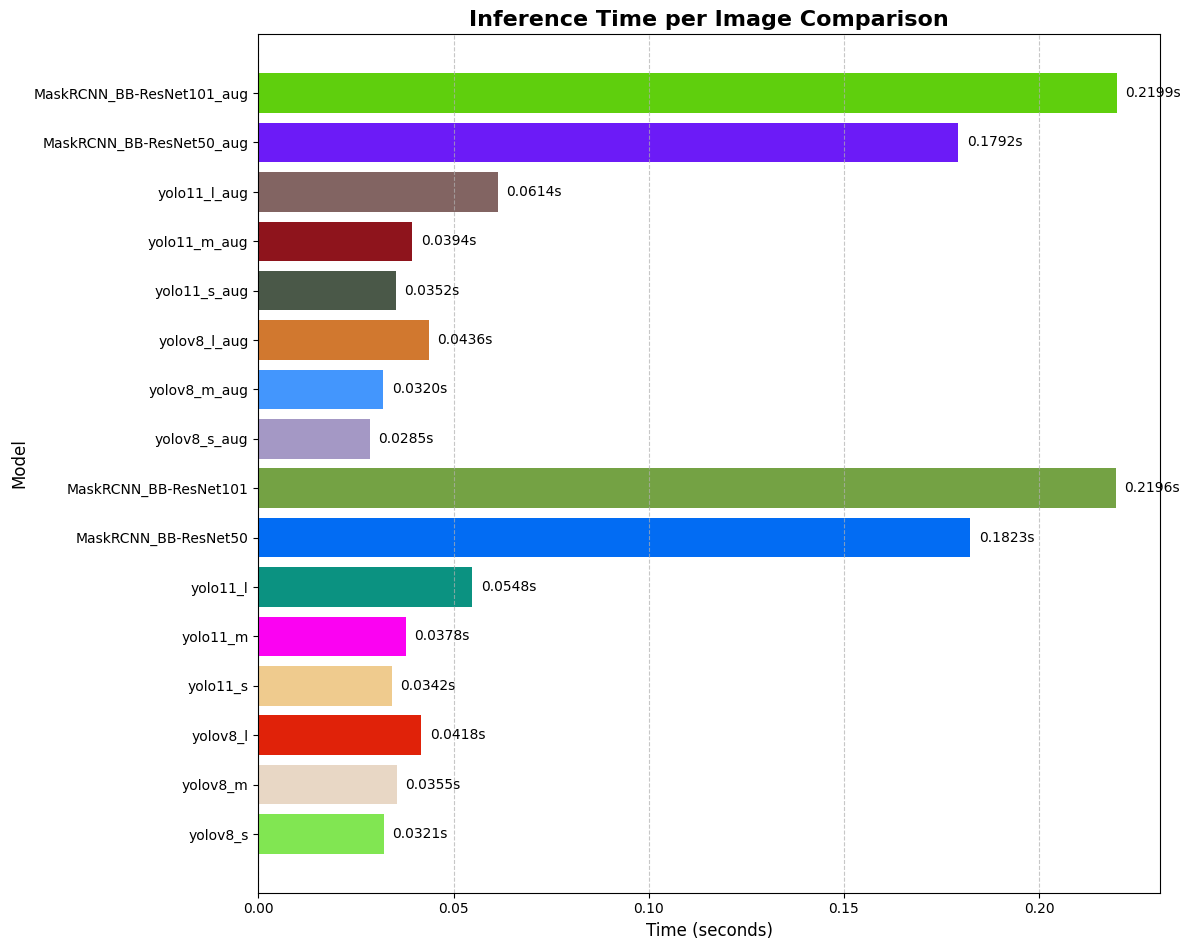


RUNTIME EVALUATION SUMMARY
yolov8_s: 0.0321s per image
yolov8_m: 0.0355s per image
yolov8_l: 0.0418s per image
yolo11_s: 0.0342s per image
yolo11_m: 0.0378s per image
yolo11_l: 0.0548s per image
MaskRCNN_BB-ResNet50: 0.1823s per image
MaskRCNN_BB-ResNet101: 0.2196s per image
yolov8_s_aug: 0.0285s per image
yolov8_m_aug: 0.0320s per image
yolov8_l_aug: 0.0436s per image
yolo11_s_aug: 0.0352s per image
yolo11_m_aug: 0.0394s per image
yolo11_l_aug: 0.0614s per image
MaskRCNN_BB-ResNet50_aug: 0.1792s per image
MaskRCNN_BB-ResNet101_aug: 0.2199s per image


In [22]:
RunTimeEvaluation(INFO_LIST, 
                class_names,
                PLOT_FOLDER = PLOT_FOLDER,
                CSV_FOLDER = CSV_FOLDER,
                IMG_SIZE = (1080, 1920), 
                INFER_NUMBER = 100, 
                WARM_UP_NUMBER = 10
                )